# RECOGNITION OF PARTIALLY OVERLAPPING HAND-WRITTEN DIGITS
## This is part of the code created for the online course on Machine Learning: MITx 6.86x: Machine Learning with Python: From linear models to Deep Learning

# MOTIVATION: 
## We intend to recognize hand-written digits (from 0 to 9) that, in addition, partially overlap. To that aim, we build and apply a convolutional neural network

# DATA

# Training images:
## 40.000 images each of size 42 x 28 pixels. Each image contains two hand-written digits (0-9), stacked vertically and partially overlapping.
# Test images:
## 4.000 images each of size 42 x 28 pixels. Each image contains two hand-written digits (0-9), stacked vertically and partially overlapping.

# Image Samples

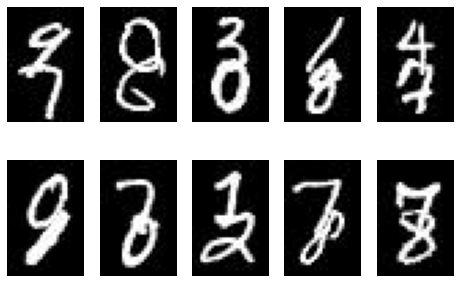

In [1]:
import random 
import matplotlib.pyplot as plt
import matplotlib.image as img

path = '/Users/daviddiegocastro/Desktop/PYTHON/EdX COURSE Sep-Dec 2020/JUPYTER NOTEBOOKS/Sample_images/'

selection = random.sample(range(20000,20100),10)
images = []
for num in selection:
    name = 'img'+str(num)+'.jpg'
    images.append(img.imread(path+name))

n_cols = 5

plt.figure(figsize = (8,8))
for i, image in enumerate(images):
    plt.subplot(int(len(images)/n_cols)+1, n_cols, i+1)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    

# IMPORTING PACKAGES

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip, _pickle
from tqdm import tqdm

# SETTING HYPER-PARAMETERS OF THE MODEL

In [3]:
img_rows, img_cols = 42, 28  # Image dimensions
batch_size = 64 # size of each batch of training and test images 
n_epochs = 30 # number of training epochs for the neural network

# PREPARING THE DATA

## Split data into batches
### The data will be split into batches of equal size. This split is not a partition of the data, since different batches may contain common data. For the training of the model, the neural network will be applied to a batch at a time (i.e. the network will be evaluated on all the images of a given batch simultanously) and the parameters of the network wil be updated on each batch evaluation. 
### The testing of the model will be also performed batch-wise and the final accuracy of the network will be computed as the mean accuracy over all batches.

In [4]:
def split_data_into_batches(x_data,y_data,batch_size):
    """
    Arguments: 
         x_data : list of N_image many 2d numpy arrays. Each array contains the pixel information of an image  
         y_data : list containing two lists of N_image many integers. 
                  The first (second) list contains the digit labels corresponding to the upper (lower) drawing 
                  in the images. 
         batch_size : integer. Specifies the size of each batch of data
    Returns:
        batches : list of dictionaries. 
                  Each dictionary contains two entries:
                  Labeled as 'x' : a list containing batch_size many elements from x_data
                  Labeled as 'y' : the digit labels corresponding to the images represented in 'x'                        
    """
    # Make sure the y_data are integers
    int_y_0 = [int(y) for y in y_data[0]]
    int_y_1 = [int(y) for y in y_data[1]]
    
    N = round(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i + batch_size],
                              dtype=torch.float32),
            'y': torch.tensor([int_y_0[i:i + batch_size],
                               int_y_1[i:i + batch_size]],
                               dtype=torch.int64)
        })
    return batches

## Getting training, validation and testing data

In [5]:
def get_data():
    """
    Returns batches for trainig, validation and test data
    """
    path_to_folder = '/Users/daviddiegocastro/Desktop/PYTHON/EdX COURSE Sep-Dec 2020/JUPYTER NOTEBOOKS/Datasets/'
    
    # Training images
    f = gzip.open(path_to_folder+'train_multi_digit_mini.pkl.gz','rb')
    X_train = _pickle.load(f,encoding='latin1')
    f.close()
    X_train = np.reshape(X_train,(len(X_train), 1, img_rows, img_cols))
    
    # Training labels
    f = gzip.open(path_to_folder+'train_labels_mini.txt.gz','rb')
    y_train = np.loadtxt(f)
    f.close()
    
    # Test images
    f = gzip.open(path_to_folder+'test_multi_digit_mini.pkl.gz','rb')
    X_test = _pickle.load(f,encoding='latin1')
    f.close()
    X_test = np.reshape(X_test,(len(X_test), 1, img_rows, img_cols))
    
    # Test labels
    f = gzip.open(path_to_folder+'test_labels_mini.txt.gz','rb')
    y_test = np.loadtxt(f)
    f.close()
    
    """
    90% of the training images will be used to train the neural network. 
    The remaining 10% will be used to validate the training
    """
    split_index = round(9 * len(X_train) / 10)
    X_val = X_train[split_index:]
    y_val = [y_train[0][split_index:], y_train[1][split_index:]]
    X_train = X_train[:split_index]
    y_train = [y_train[0][:split_index], y_train[1][:split_index]]

    permutation = np.array([i for i in range(len(X_train))])
    np.random.shuffle(permutation)
    X_train = [X_train[i] for i in permutation]
    y_train = [[y_train[0][i] for i in permutation], [y_train[1][i] for i in permutation]]

    """
    Split the data into batches
    """
    train_data = split_data_into_batches(X_train,y_train,batch_size)
    val_data = split_data_into_batches(X_val,y_val,batch_size)
    test_data = split_data_into_batches(X_test,y_test,batch_size)
    
    return train_data, val_data, test_data

# Generating accuracy and loss plots

In [6]:
def Plots(loss, acc):
    
    plt.rc('xtick',labelsize = 10)
    plt.rc('ytick',labelsize = 10)
    
    fig, ax = plt.subplots(2,2,sharex=True)
    
    x = np.arange(1,loss.shape[0]+1)
    ax[0,0].plot(x,loss[:,0],'-r',linewidth=2)
    ax[1,0].plot(x,loss[:,1],'-r',linewidth=2)
    ax[0,1].plot(x,acc[:,0],'-b',linewidth=2)
    ax[1,1].plot(x,acc[:,1],'-b',linewidth=2)
    
    ax[0,1].tick_params(labelsize=10,labelbottom=False,
                        labelleft=False,labelright=True)
    ax[1,1].tick_params(labelsize=10,labelbottom=True,
                        labelleft=False,labelright=True)
    
    ax[1,0].set_xlabel('epoch',fontsize=10)
    ax[1,1].set_xlabel('epoch',fontsize=10)
    
    ax[0,0].set_title('loss up. digit')
    ax[1,0].set_title('loss low. digit')
    ax[0,1].set_title('accur. up. digit')
    ax[1,1].set_title('accur. low. digit')
    
    plt.show()
    
    return None 

# THE CONVOLUTIONAL MODEL

## Initialization of the model

In [7]:
class CNN (nn.Module):
    def __init__(self, filter_size=3, maxpool_size=2, n_channels=5):
        super(CNN, self).__init__()
        """
        The output are two 2d arrays corresponding to the predictions 
        of the upper and lower digits in each image (see note below)
        """
        # Input size : img_rows x img:cols
        # Convolutional filter
        self.conv_layer = nn.Conv2d(1,n_channels,(filter_size,filter_size))
        # The output of the conv. filter has size : dim1 x dim2, where
        dim1 = img_rows-filter_size+1
        dim2 = img_cols-filter_size+1
        
        # Activation function
        self.activation = nn.ReLU()
        
        # Max pool filter
        self.maxpool = nn.MaxPool2d((maxpool_size,maxpool_size))
        # The output of the max pool filter has size : dim1 x dim2, where
        dim1 = int((dim1-maxpool_size)/maxpool_size+1)
        dim2 = int((dim2-maxpool_size)/maxpool_size+1)
        
        # Flattening the data
        self.flatten = flat_output()
        
        # Drop out filter
        self.drop_out = nn.Dropout()
        
        # Fully connected layer
        self.linear = nn.Linear(n_channels*dim1*dim2,20)

    def forward(self, x):

        # Apply conv. filter 
        out = self.conv_layer(x)
        # Apply acitvation function
        out = self.activation(out)
        # Apply max pool filter
        out = self.maxpool(out)
        # flatten the output 
        out = self.flatten(out)
        # Apply a dropout filter
        out = self.drop_out(out)
        # Apply a fully connected linear layer
        out = self.linear(out)
        
        # Get predictions for the upper and lower digits 
        out_first_digit = out[:,0:10]
        out_second_digit = out[:,10:]

        return out_first_digit, out_second_digit
    
class flat_output(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
         

## NOTE: The outcome of the neural network are two 2d numpy arrays, out1 and out2 where out1[i,:] corresponds to the upper digit in the i-th image of the batch (and similarly for out2). 

## Predicting the digits:

### $out1[i,:]$ is an array with 10 real numbers, say $out1[i,:] = [r_0,\cdots,r_9]$ (possibly negative). In order to decide to what digit this array corresponds we take a soft-max transformation, that is 
$$r_i\mapsto P_i:=\frac{e^{r_i}}{\sum_{j= 0}^9 e^{r_j}}$$
### which can be interpreted as a probability distribution over the digits. The represented digit is then the most likely, namely: $argmax(\left\{P_0,\cdots,P_9\right\})$. Of course, this is equivalent to $argmax(out1[i,:])$, which is what we will do in our case.    

# TRAINING THE MODEL

## Evaluating the neural network on the data  

In [8]:
def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.numpy(), y.numpy()))



def eval_network(data, model, optimizer):
    """
    Evaluates the neural network on data, either for training or evalutaion
    
    Returns:
    avg_loss: tuple (average loss for 1st digit, average loss for 1st digit) 
    avg_acc: tuple (average batch accuracy for 1st digit, average batch accuracy for 1st digit)
    """
    
    losses_upper_digit = []
    losses_lower_digit = []
    batch_accuracies_up = []
    batch_accuracies_down = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions for both the upper and lower digits
        out1, out2 = model(x)

        # Predict and store accuracy
        predictions_upper_digit = torch.argmax(out1, dim=1)
        predictions_lower_digit = torch.argmax(out2, dim=1)
        batch_accuracies_up.append(compute_accuracy(predictions_upper_digit, y[0]))
        batch_accuracies_down.append(compute_accuracy(predictions_lower_digit, y[1]))

        # Compute both losses
        loss1 = F.cross_entropy(out1, y[0])
        loss2 = F.cross_entropy(out2, y[1])
        losses_upper_digit.append(loss1.data.item())
        losses_lower_digit.append(loss2.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            joint_loss = 0.5 * (loss1 + loss2)
            joint_loss.backward()
            optimizer.step()

    if is_training:
        return None
    else:
        # Calculate epoch level scores
        avg_loss = np.mean(losses_upper_digit), np.mean(losses_lower_digit)
        avg_accuracy = np.mean(batch_accuracies_up), np.mean(batch_accuracies_down)
        return avg_loss, avg_accuracy 
    

## Training the neural network

In [9]:
def train_model(train_data, val_data, model, 
                lr = 0.01, momentum = 0.9, nesterov = False,
                n_epochs = 30):
    """
    Train the network for n_epochs given the model hyper-parameters 
    """
    # Setting the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    
    val_losses = np.zeros((n_epochs,2))
    val_acc = np.zeros((n_epochs,2))
    
    for epoch in range(1, n_epochs + 1):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Train the neural network
        eval_network(train_data, model.train(), optimizer)
        
        # Evaluate the network on the validation data
        loss, acc = eval_network(val_data, model.eval(), optimizer)
        
        val_losses[epoch-1,:] = np.array(loss) 
        val_acc[epoch-1,:] = np.array(acc) 
    return val_losses, val_acc
        

# RUN THE MODEL

In [10]:
# Extract the date
train_data, val_data, test_data = get_data()
    
# Initialize the neural network
model = CNN()

# Train the neural network
val_loss, val_acc = train_model(train_data, val_data, model, n_epochs=n_epochs)

# Evaluate the neural network on the test data
test_loss, test_acc = eval_network(test_data, model.eval(), None)
    

  2%|▏         | 11/562 [00:00<00:05, 107.23it/s]

-------------
Epoch 1:



  2%|▏         | 14/562 [00:00<00:04, 131.58it/s]

-------------
Epoch 2:



  2%|▏         | 13/562 [00:00<00:04, 128.45it/s]

-------------
Epoch 3:



  2%|▏         | 14/562 [00:00<00:04, 131.85it/s]

-------------
Epoch 4:



  2%|▏         | 13/562 [00:00<00:04, 128.75it/s]

-------------
Epoch 5:



  2%|▏         | 12/562 [00:00<00:04, 116.20it/s]

-------------
Epoch 6:



  2%|▏         | 13/562 [00:00<00:04, 124.20it/s]

-------------
Epoch 7:



  2%|▏         | 12/562 [00:00<00:04, 119.45it/s]

-------------
Epoch 8:



  2%|▏         | 13/562 [00:00<00:04, 126.34it/s]

-------------
Epoch 9:



  2%|▏         | 13/562 [00:00<00:04, 121.90it/s]

-------------
Epoch 10:



  2%|▏         | 13/562 [00:00<00:04, 123.11it/s]

-------------
Epoch 11:



  2%|▏         | 12/562 [00:00<00:04, 114.32it/s]

-------------
Epoch 12:



  2%|▏         | 12/562 [00:00<00:04, 117.39it/s]

-------------
Epoch 13:



  2%|▏         | 11/562 [00:00<00:05, 104.97it/s]

-------------
Epoch 14:



  2%|▏         | 9/562 [00:00<00:06, 89.78it/s]

-------------
Epoch 15:



  2%|▏         | 12/562 [00:00<00:04, 116.89it/s]

-------------
Epoch 16:



  2%|▏         | 12/562 [00:00<00:04, 117.53it/s]

-------------
Epoch 17:



  2%|▏         | 12/562 [00:00<00:04, 115.64it/s]

-------------
Epoch 18:



  2%|▏         | 12/562 [00:00<00:04, 119.45it/s]

-------------
Epoch 19:



  2%|▏         | 12/562 [00:00<00:04, 115.56it/s]

-------------
Epoch 20:



  2%|▏         | 13/562 [00:00<00:04, 121.47it/s]

-------------
Epoch 21:



  2%|▏         | 12/562 [00:00<00:04, 119.11it/s]

-------------
Epoch 22:



  2%|▏         | 12/562 [00:00<00:04, 119.83it/s]

-------------
Epoch 23:



  2%|▏         | 12/562 [00:00<00:04, 112.22it/s]

-------------
Epoch 24:



  2%|▏         | 12/562 [00:00<00:04, 119.15it/s]

-------------
Epoch 25:



  2%|▏         | 12/562 [00:00<00:04, 118.90it/s]

-------------
Epoch 26:



  2%|▏         | 12/562 [00:00<00:04, 113.52it/s]

-------------
Epoch 27:



  2%|▏         | 13/562 [00:00<00:04, 121.50it/s]

-------------
Epoch 28:



  2%|▏         | 13/562 [00:00<00:04, 121.18it/s]

-------------
Epoch 29:



  2%|▏         | 12/562 [00:00<00:04, 111.41it/s]

-------------
Epoch 30:



100%|██████████| 62/62 [00:00<00:00, 259.69it/s]


## Plot the validation results

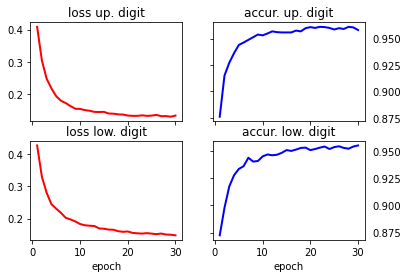

In [11]:
Plots(val_loss, val_acc)

## Test results

In [12]:
print("TEST | loss upper digit: {:.6f}, accuracy upper digit: {:.6f}".format(test_loss[0],test_acc[0]))
print("TEST | loss lower digit: {:.6f}, accuracy lower digit: {:.6f}".format(test_loss[1],test_acc[1]))

TEST | loss upper digit: 0.129275, accuracy upper digit: 0.962702
TEST | loss lower digit: 0.146236, accuracy lower digit: 0.948841
